In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


In [3]:
def depth_first(graph, source, visited):
    visited[source] = 1
    for i in range(len(graph)):
        if graph[source][i] != 0 and not visited[i]:
            depth_first(graph, i, visited)

class MarkovChain:
    def __init__(self, n, states, transMatrix, initialState):
        self.states = states
        self.initialProb = initialState
        self.transitionMatrix = transMatrix
        self.numStates = n

    def holdStateUsingMatrix(self,start,end,steps=50):
        initial=np.zeros(self.numStates)
        initial[start]=1
        probabilities=[initial]

        for _ in range(steps):
            next_state = probabilities[-1] @ self.transitionMatrix
            probabilities.append(next_state)
        # print(probabilities[-1])

        probabilities = np.array(probabilities)
        plt.figure(figsize=(10, 6))
        for i in end:
            plt.plot(probabilities[:, i], label=f"State S{i}",linewidth=0.75)
        plt.axhline(y=1/6, color='r', linestyle='--',linewidth=0.5, label='y = 1/6')
        plt.title(f"Probability of Being At State {end} at Step x starting from state {start}")
        plt.xlabel("Time Steps")
        plt.ylabel("Probability")
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.show()

    def reachableStates(self):
        reachable = np.zeros((self.numStates, self.numStates), dtype=int)
        # reachable=[[0]*self.numStates]*self.numStates # does not work due to shallow copies' creation
        #print(reachable)

        for source in range(self.numStates):
            visited = [0] * self.numStates
            depth_first(self.transitionMatrix, source, visited)
            for i in range(self.numStates):
                if visited[i]:
                    reachable[source][i] = 1

        # print("later")
        #print(reachable)
        
        return reachable

    def findPreStates(self, goal:list):
        preSet=[]
        predecessors=self.reachableStates()
        for i in range(self.numStates):
            if i in goal:
                continue
            if any(predecessors[i][state] for state in goal):
                preSet.append(i)

        return preSet
    
    
    def powerMethod(self,goals,plot,iter=100,epsilon=0.000001):
        """
        Performs the Power Method to solve the system of equations.
        """
        # length=len(self.findPreStates(goals))
        preSet=self.findPreStates(goals)
        length=len(preSet)
        values=[]

        a = np.zeros((length,length))
        b = np.zeros((length,1))

        for i in range(length):
            b[i]=sum(self.transitionMatrix[preSet[i]][j] for j in goals)
            for j in range(length):
                a[i][j]=self.transitionMatrix[preSet[i]][preSet[j]]

        x = np.zeros((length,1))
        y = np.matmul(a, x) + b

        for i in range(iter):
            # if np.max(np.abs(x - y)) <= epsilon:
            #     print(f"power method converges after {i} steps")
            #     break
            values.append(x.copy())
            x = y
            y = np.matmul(a, x) + b

        I=np.zeros((length,length))
        for i in range(length):
            I[i][i]=1
        z=np.linalg.solve(I-a,b)

        print("Eventually reaching pre states")
        for i in preSet:
            print(f"{i}:{x[preSet.index(i)]}")

        if plot:
            step=len(values)
            arr=np.array([v.flatten() for v in values])

            plt.figure()
            for iAmMiserableandIwantToSleep in range(length):
                plt.plot(range(step), arr[:, iAmMiserableandIwantToSleep], linestyle='-', label=f'x({preSet[iAmMiserableandIwantToSleep]})')

            plt.xlabel('step')
            plt.ylabel('Value')
            plt.legend(loc="upper right")
            plt.title('Power Method Convergence')
            plt.show()

        return x,values

    
    ## WRONG: Just ignore please
    # def plot_cumulative_first_passage_probabilities(self, start, end, n=50):
    #     """
    #     Calculates and plots the cumulative probabilities of reaching the 'end' states
    #     from the 'start' state for the first time at each step from 1 to n.
    #     """
    #     state_vector = [0]*self.numStates
    #     state_vector[start] = 1 

    #     first_passage_probabilities={e: [] for e in end}
    #     absorbed_probabilities=[0]*self.numStates

    #     for step in range(1, n + 1):
    #         next_state_vector = state_vector @ self.transitionMatrix

    #         for e in end:
    #             first_passage_probability = next_state_vector[e] - absorbed_probabilities[e]
    #             first_passage_probabilities[e].append(max(0, first_passage_probability))

    #         for e in end:
    #             absorbed_probabilities[e] += next_state_vector[e]

    #         for e in end:
    #             next_state_vector[e] = 0

    #         state_vector = next_state_vector

    #     cumulative_probabilities = {e: np.cumsum(first_passage_probabilities[e]) for e in end}

    #     plt.figure(figsize=(10, 6))
        
    #     for e in end:
    #         plt.plot(range(1, n + 1),cumulative_probabilities[e],marker='o',linestyle='-',label=f"Cumulative First-Passage P(S{e} | S{start})")

    #     plt.title(f"Cumulative First-Passage Probabilities to End States {end} from S{start}", fontsize=16)
    #     plt.xlabel("Number of Steps", fontsize=14)
    #     plt.ylabel("Cumulative Probability", fontsize=14)
    #     plt.xticks(range(1, n + 1, max(1, n // 10)))
    #     plt.legend(loc="upper right")
    #     plt.grid(True)
    #     plt.show()


In [12]:
##please do not use this for a picture of the chain
##this was just a check for the matrix
def visualize_markov_chain(transition_matrix):
    G = nx.DiGraph()
    numStates = transition_matrix.shape[0]
    nodes = [f"S{i}" for i in range(numStates)]
    G.add_nodes_from(nodes)

    for i in range(numStates):
        for j in range(numStates):
            if transition_matrix[i, j] > 0:
                G.add_edge(f"S{i}", f"S{j}", weight=transition_matrix[i, j])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(10,12))
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
    edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title("Markov Chain Visualization", fontsize=16)
    plt.axis("off")
    plt.show()

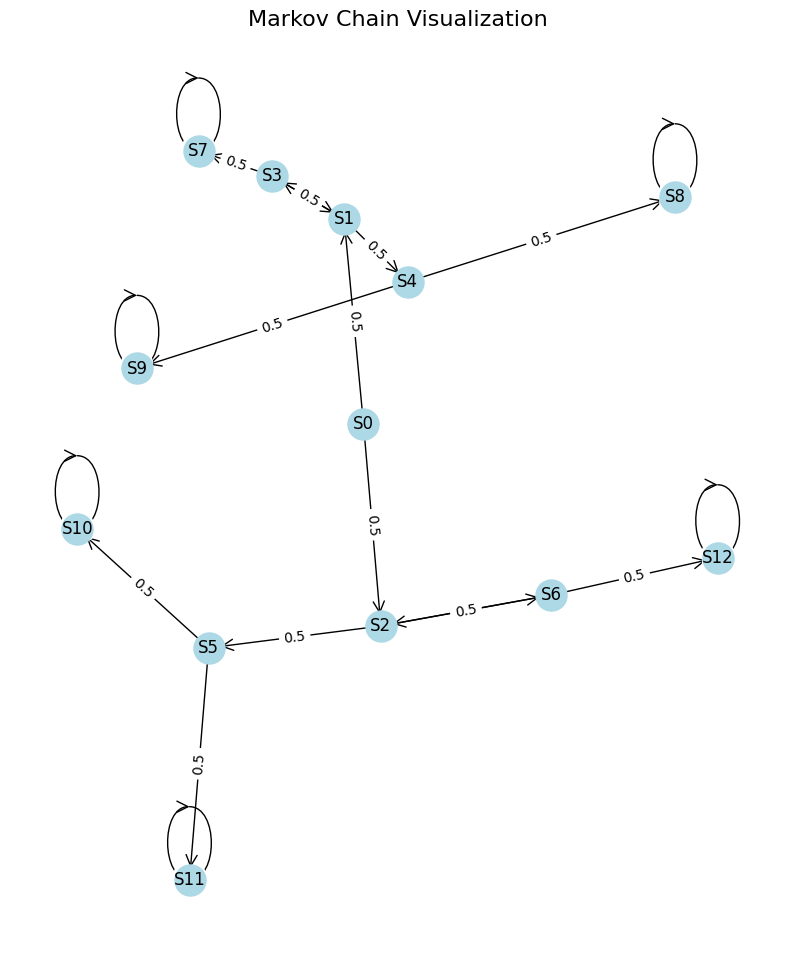

In [13]:
transition_matrix = np.array([
    #0  1    2    3    4    5    6    7    8    9    10   11   12
    [0, 0.5, 0.5, 0,   0,   0,   0,   0,   0,   0,   0,   0,   0],  # S0
    [0, 0,   0,   0.5, 0.5, 0,   0,   0,   0,   0,   0,   0,   0],  # S1
    [0, 0,   0,   0,   0,   0.5, 0.5, 0,   0,   0,   0,   0,   0],  # S2
    [0, 0.5, 0,   0,   0,   0,   0, 0.5,   0,   0,   0,   0,   0],  # S3
    [0, 0,   0,   0,   0,   0,   0,   0, 0.5,  0.5,  0,   0,   0],      # S4
    [0, 0,   0,   0,   0,   0,   0,   0,   0,   0, 0.5,  0.5,  0],  # S5
    [0, 0,   0.5, 0,   0,   0,   0,   0,   0,   0,   0,   0,   0.5],  # S6
    [0, 0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],      # S7
    [0, 0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],      # S8
    [0, 0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0],      # S9
    [0, 0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0],      # S10
    [0, 0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0],      # S11
    [0, 0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1]])     # S12

n=13
initial_state=[1,0,0,0,0,0,0,0,0,0,0,0,0]
states=['S0','S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12']

coinToss = MarkovChain(len(states), states, transition_matrix, initial_state)

# just a sanity check on the transition matrix
# visualize_markov_chain(transition_matrix)


The following plot can be investigated better if you run it in a .py file instead and when the plot appear use the zoom operation of the matplotlib window to investigate the curve's behaviour close to the x axis at later steps (the probability is non zero)

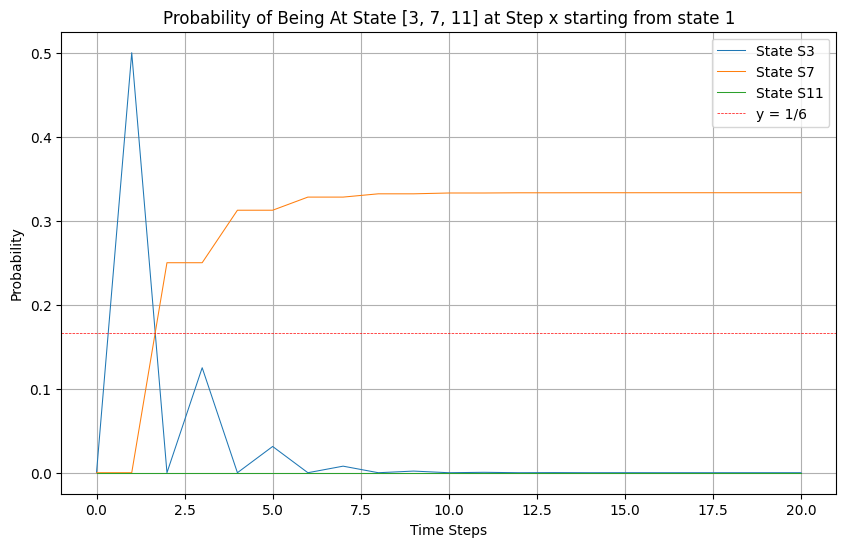

In [6]:
#state i at step j
start_state=1
end_states=[3,7,11]
coinToss.holdStateUsingMatrix(start_state, end_states,20)

Eventually reaching pre states
0:[0.16666667]
2:[0.33333333]
5:[0.5]
6:[0.16666667]


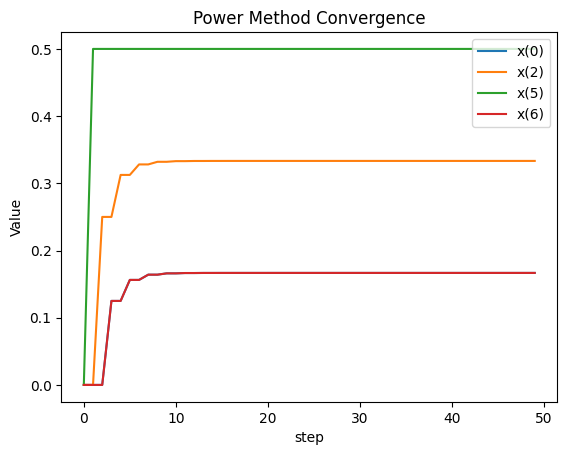

pre states for S5 [0, 2, 6]
pre states for S3 [0, 1]


In [7]:
x,vals=coinToss.powerMethod([11],True,iter=50, epsilon=0.000001)
print("pre states for S5",coinToss.findPreStates([5]))
print("pre states for S3",coinToss.findPreStates([3]))
# print(x,vals)

Now observing the difference between the power convergence and hold state functions' graphs (they are performing different tasks)

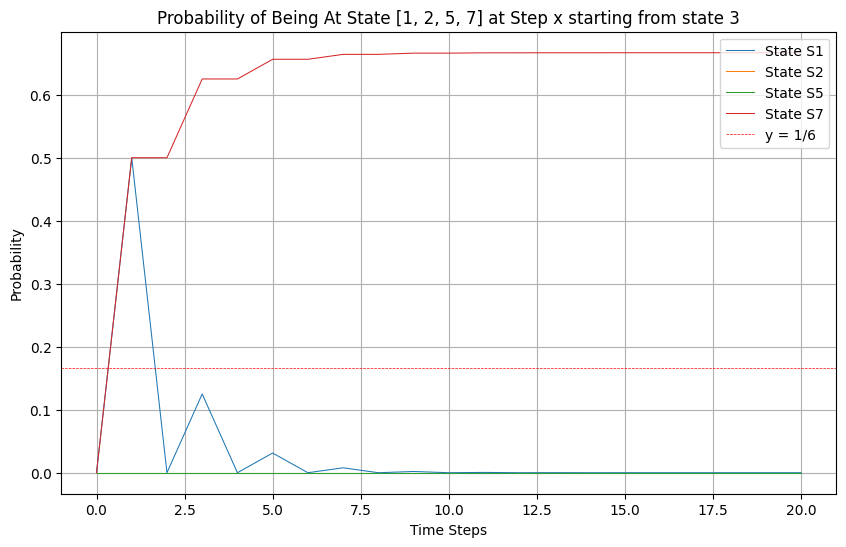

Eventually reaching pre states
0:[0.5]
3:[0.5]


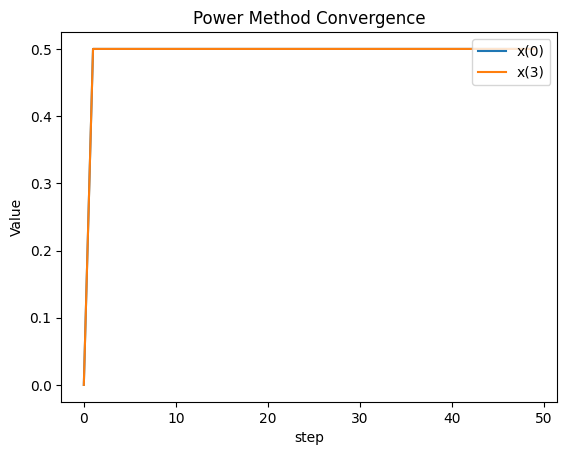

Eventually reaching pre states
0:[0.5]
6:[0.5]


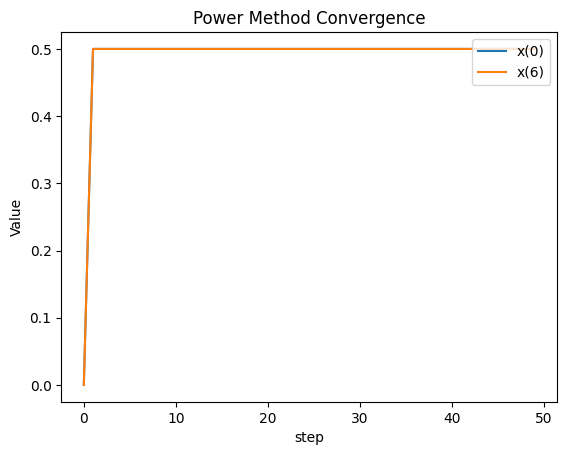

Eventually reaching pre states
0:[0.33333333]
2:[0.66666667]
6:[0.33333333]


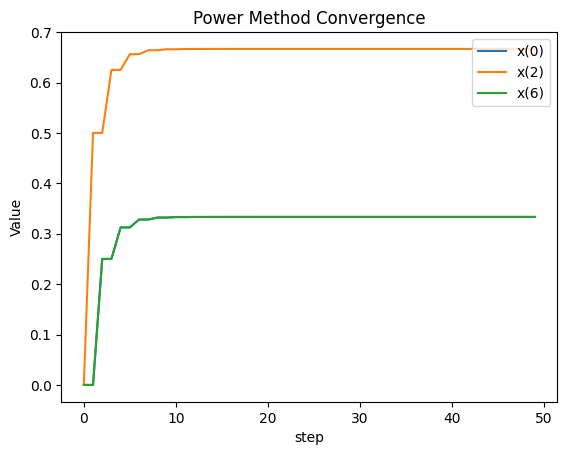

Eventually reaching pre states
0:[0.16666667]
1:[0.33333333]
3:[0.66666667]


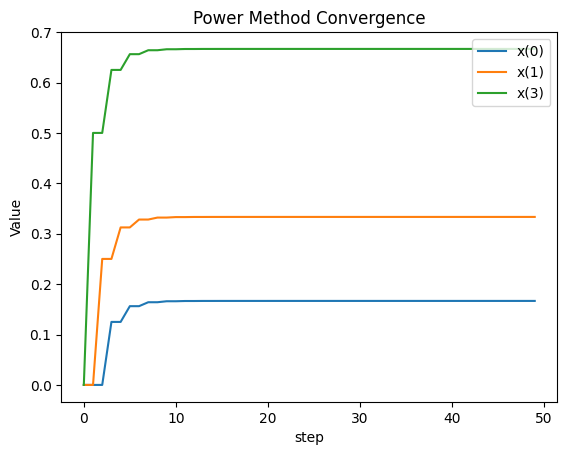

(array([[0.16666667],
        [0.33333333],
        [0.66666667]]),
 [array([[0.],
         [0.],
         [0.]]),
  array([[0. ],
         [0. ],
         [0.5]]),
  array([[0.  ],
         [0.25],
         [0.5 ]]),
  array([[0.125],
         [0.25 ],
         [0.625]]),
  array([[0.125 ],
         [0.3125],
         [0.625 ]]),
  array([[0.15625],
         [0.3125 ],
         [0.65625]]),
  array([[0.15625 ],
         [0.328125],
         [0.65625 ]]),
  array([[0.1640625],
         [0.328125 ],
         [0.6640625]]),
  array([[0.1640625 ],
         [0.33203125],
         [0.6640625 ]]),
  array([[0.16601562],
         [0.33203125],
         [0.66601562]]),
  array([[0.16601562],
         [0.33300781],
         [0.66601562]]),
  array([[0.16650391],
         [0.33300781],
         [0.66650391]]),
  array([[0.16650391],
         [0.33325195],
         [0.66650391]]),
  array([[0.16662598],
         [0.33325195],
         [0.66662598]]),
  array([[0.16662598],
         [0.33331299],


In [8]:
coinToss.holdStateUsingMatrix(3, [1,2,5,7],20)
coinToss.powerMethod([1],True,iter=50, epsilon=0.000001)
coinToss.powerMethod([2],True,iter=50, epsilon=0.000001)
coinToss.powerMethod([5],True,iter=50, epsilon=0.000001)
coinToss.powerMethod([7],True,iter=50, epsilon=0.000001)